In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import dc_stat_think as dcst

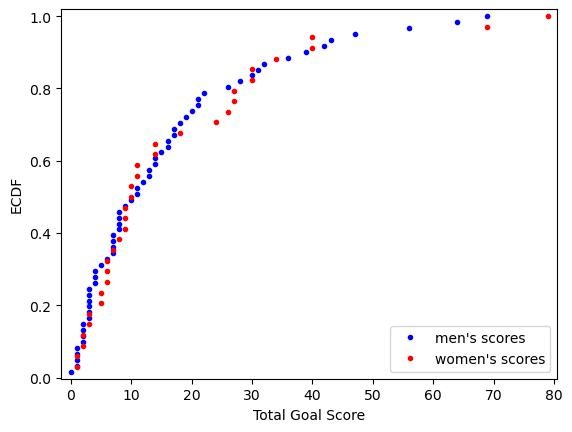

In [14]:
# Initial Graphical Exploratory Analysis

# Import data
df_m = pd.read_csv('men_results.csv')
df_w = pd.read_csv('women_results.csv')

# Parse date column 
df_m['date'] = pd.to_datetime(df_m['date']).dt.strftime('%Y-%m-%d')
df_w['date'] = pd.to_datetime(df_w['date']).dt.strftime('%Y-%m-%d')

# Slice data as per conditions
df_m = df_m[(df_m['tournament'] == "FIFA World Cup") & (df_m['date'] >= "2002-01-01")]
df_w = df_w[(df_w['tournament'] == "FIFA World Cup") & (df_w['date'] >= "2002-01-01")]

# Group and transform data 
df_m_grouped = df_m.groupby('home_team')[['home_score', 'away_score']].sum()
df_w_grouped = df_w.groupby('home_team')[['home_score', 'away_score']].sum()


# Summarize
df_m_grouped['total_score'] = np.sum([df_m_grouped['home_score'], df_m_grouped['away_score']], axis=0)
df_w_grouped['total_score'] = np.sum([df_w_grouped['home_score'], df_w_grouped['away_score']], axis=0)

# Reshape
df_m_clean = df_m_grouped.drop(['home_score', 'away_score'], axis=1)
df_w_clean = df_w_grouped.drop(['home_score', 'away_score'], axis=1)

# Make x and y arrays to plot ecdf
x_m = np.sort(df_m_clean['total_score'])
n_m = len(x_m)
y_m = np.arange(1, n_m+1)/n_m

x_w = np.sort(df_w_clean['total_score'])
n_w = len(x_w)
y_w = np.arange(1, n_w+1)/n_w

# Plot ECDF
_ = plt.plot(x_m, y_m, marker='.', linestyle='none', color='blue')
_ = plt.plot(x_w, y_w, marker='.', linestyle='none', color='red')
_ = plt.xlabel('Total Goal Score')
_ = plt.ylabel('ECDF')
_ = plt.legend(('men\'s scores', 'women\'s scores'), loc='lower right')
plt.margins(0.02)
plt.show()

In [16]:
# Computing p-value with Permutation Test

# Compute the mean
df_m_clean_mean = np.mean(df_m_clean['total_score'])
df_w_clean_mean = np.mean(df_w_clean['total_score'])

# Compute difference of means (Observed Test Statistic)
diff_of_means_observed = df_w_clean_mean - df_m_clean_mean

# Generate replicates
perm_replicates = dcst.draw_perm_reps(df_w_clean['total_score'], df_m_clean['total_score'], dcst.diff_of_means, 10000)

# Compute p-value
p = np.sum(perm_replicates >= diff_of_means_observed)/10000

# Print p-value
print('p-value: ', p)

p-value:  0.3148


In [32]:
# Running a bootstrap hypothesis test in order to compute the p-value and 95% Confidence Interval

# Compute combined mean to normalise datasets
combined_mean = (df_m_clean_mean + df_w_clean_mean) / 2

# new arrays to perform bootstrap on
men_shifted = (df_m_clean - df_m_clean_mean) + combined_mean
women_shifted = (df_w_clean - df_w_clean_mean) + combined_mean

# Acquire 10000 replicates of means
replicates_m = dcst.draw_bs_reps(men_shifted['total_score'], np.mean, size=10000)
replicates_w = dcst.draw_bs_reps(women_shifted['total_score'], np.mean, size=10000)

# Compute difference of means for replicates (Sample Test Statistic)
diff_of_means_reps = replicates_w - replicates_m

# Compute p-value
p = np.sum(diff_of_means_reps >= diff_of_means_observed)/len(diff_of_means_reps)

print('p-value: ', p)

# Compute 95% Confidence Interval
conf_int = np.percentile(diff_of_means_reps, [2.5, 97.5])
conclusion = "Conclusion: Assuming a significance level of 10% (0.1): \n Since the p-value is not less than 0.1, we fail to reject the null hypothesis\n and can conclude that there is not enough evidence to support the alternative hypothesis."
print('Difference of means: ', diff_of_means_observed,'\n' '95% Confidence Interval: ', conf_int, '\n', conclusion)


p-value:  0.3193
Difference of means:  1.7097396335583426 
95% Confidence Interval:  [-6.98997107  7.67172131] 
 Conclusion: Assuming a significance level of 10% (0.1): 
 Since the p-value is not less than 0.1, we fail to reject the null hypothesis
 and can conclude that there is not enough evidence to support the alternative hypothesis.


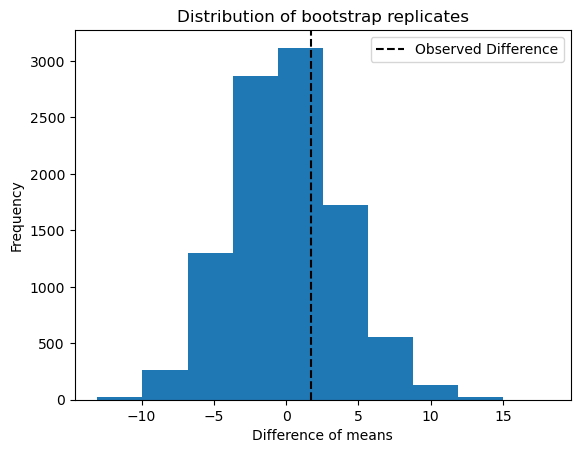

In [33]:
# Histogram of difference of mean (replicates vs observed)
_ = plt.hist(diff_of_means_reps)
# Add a vertical line for the observed difference of means
plt.axvline(diff_of_means_observed, color='black', linestyle='--', label='Observed Difference')
plt.xlabel('Difference of means')
plt.ylabel('Frequency')
plt.title('Distribution of bootstrap replicates')
plt.legend()
plt.show()